# 🚀 Optimized LLM vs .pth Model Game Simulation

**เป้าหมาย**: เปรียบเทียบประสิทธิภาพ LLM Strategy vs .pth Model + MCTS อย่างรวดเร็ว

**การปรับปรุง**:
- ✅ ใช้ Singleton Pattern สำหรับ Model
- ✅ LLM เลือกกลยุทธ์ครั้งเดียวต่อเกม
- ✅ ใช้ MCTS จริง (Medium mode)
- ✅ ปิด verbose เพื่อความเร็ว
- ✅ Memory optimization

In [1]:
# ========== 1. Setup และ Import Libraries ==========
print("🔧 กำลังตั้งค่าระบบ...")

import sys
import os
import torch
import random
import time
import pandas as pd
import sqlite3
import re
from typing import Dict, List, Any, Optional, Tuple
from contextlib import redirect_stderr
import io
from datetime import datetime

# เพิ่ม path
current_dir = os.getcwd()
paths_to_add = [
    current_dir,
    os.path.join(current_dir, 'app'),
    os.path.join(current_dir, 'app', 'ai'),
    os.path.join(current_dir, 'app', 'llm')
]

for path in paths_to_add:
    if path not in sys.path:
        sys.path.append(path)
        print(f"✅ เพิ่ม path: {path}")

print("✅ Setup เสร็จสิ้น")

🔧 กำลังตั้งค่าระบบ...
✅ เพิ่ม path: c:\university\nsc\agent-maknib\app\llm
✅ เพิ่ม path: c:\university\nsc\agent-maknib\app\llm\app
✅ เพิ่ม path: c:\university\nsc\agent-maknib\app\llm\app\ai
✅ เพิ่ม path: c:\university\nsc\agent-maknib\app\llm\app\llm
✅ Setup เสร็จสิ้น
✅ เพิ่ม path: c:\university\nsc\agent-maknib\app\llm
✅ เพิ่ม path: c:\university\nsc\agent-maknib\app\llm\app
✅ เพิ่ม path: c:\university\nsc\agent-maknib\app\llm\app\ai
✅ เพิ่ม path: c:\university\nsc\agent-maknib\app\llm\app\llm
✅ Setup เสร็จสิ้น


In [2]:
# ========== 3. Database Handler ==========
print("🗄️ กำลังโหลด Database Handler...")
from typing import List
import os
import sqlite3

class StrategyDatabase:
    def __init__(self, db_path=None):
        if db_path is None:
            current_dir = os.getcwd()
            project_root = os.path.dirname(os.path.dirname(current_dir))
            db_path = os.path.abspath(os.path.join(project_root, 'app', 'strategies.db'))
        self.db_path = db_path
        self.conn = None
        self.has_strategies = False
        self.connect()

    def connect(self):
        try:
            self.conn = sqlite3.connect(self.db_path)
            print(f"✅ เชื่อมต่อฐานข้อมูล: {self.db_path}")
            cursor = self.conn.cursor()
            cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
            tables = [row[0] for row in cursor.fetchall()]
            print(f"📋 ตารางที่พบ: {tables}")
            if 'strategies' in tables:
                self.has_strategies = True
                print("✅ พบตาราง strategies")
            else:
                print("⚠️ ไม่พบตาราง strategies ใน database นี้")
        except Exception as e:
            print(f"❌ ไม่สามารถเชื่อมต่อฐานข้อมูล: {e}")

    def get_all_strategies(self) -> List[str]:
        if not self.has_strategies:
            return []
        try:
            cursor = self.conn.cursor()
            cursor.execute("SELECT DISTINCT strategy FROM strategies ORDER BY strategy")
            strategies = [row[0] for row in cursor.fetchall()]
            return strategies
        except Exception as e:
            print(f"❌ ไม่สามารถดึงรายการกลยุทธ์: {e}")
            return []

    def get_strategy_action_sequences(self, strategy: str) -> List[str]:
        if not self.has_strategies:
            return []
        try:
            cursor = self.conn.cursor()
            cursor.execute("SELECT action_sequence FROM strategies WHERE strategy = ? ORDER BY game_number", (strategy,))
            sequences = [row[0] for row in cursor.fetchall()]
            return sequences
        except Exception as e:
            print(f"❌ ไม่สามารถดึง action_sequence สำหรับ {strategy}: {e}")
            return []

    def get_strategy_actions_by_game(self, strategy: str, game_number: int) -> List[str]:
        if not self.has_strategies:
            return []
        try:
            cursor = self.conn.cursor()
            cursor.execute("SELECT action_sequence FROM strategies WHERE strategy = ? AND game_number = ?", (strategy, game_number))
            row = cursor.fetchone()
            if row and row[0]:
                actions = [a.strip() for a in row[0].split(',') if a.strip()]
                return actions
            return []
        except Exception as e:
            print(f"❌ ไม่สามารถดึง actions สำหรับ {strategy} (game {game_number}): {e}")
            return []

# สร้าง database instance
db = StrategyDatabase()
all_strategies = db.get_all_strategies()
strategies_text = ", ".join(all_strategies[:20])  # แสดง 20 กลยุทธ์แรก
print(f"📋 พบ {len(all_strategies)} กลยุทธ์ในฐานข้อมูล")
print(f"📝 ตัวอย่าง: {strategies_text}...")
print("✅ Database Handler พร้อมใช้งาน")

🗄️ กำลังโหลด Database Handler...
✅ เชื่อมต่อฐานข้อมูล: c:\university\nsc\agent-maknib\app\strategies.db
📋 ตารางที่พบ: ['strategies']
✅ พบตาราง strategies
📋 พบ 36 กลยุทธ์ในฐานข้อมูล
📝 ตัวอย่าง: กวนน้ำจับปลา, ขึ้นบ้านชักบันได, คบไกลตีใกล้, จักจั่นลอกคราบ, จับโจรเอาหัวโจก, จูงแพะติดมือ, ชี้ต้นหม่อนด่าต้นไหว, ซ่อนดาบในรอยยิ้ม, ดูไฟชายฝั่ง, ตีชิงตามไฟ, ตีหญ้าให้งูตื่น, ต้นไม้ผลิดอก, ถอนฟืนใต้กระทะ, ทุกข์กาย, ปิดประตูจับโจร, ปิดฟ้าข้ามทะเล, มีในไม่มี, ยืมซากคืนชีพ, ยืมดาบฆ่าคน, ยืมทางพรางกล...
✅ Database Handler พร้อมใช้งาน


In [3]:
import os
project_root = os.path.dirname(os.path.dirname(os.getcwd()))
db_path = os.path.join(project_root, 'app', 'strategies.db')
db_path = os.path.abspath(db_path)
print(db_path)
print(os.path.exists(db_path))

c:\university\nsc\agent-maknib\app\strategies.db
True


In [4]:
# ========== 5. PTH Model + MCTS Singleton (ปรับใช้ hard) ==========
print("🤖 กำลังโหลด .pth Model + MCTS...")

# เพิ่ม numpy import
import numpy as np

# กำหนด device ก่อนใช้งานทุกจุด
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ModelSingleton:
    _instance = None
    _model = None
    _mcts_pool = None

    def __new__(cls):
        if cls._instance is None:
            cls._instance = super().__new__(cls)
        return cls._instance

    def get_model_and_mcts(self):
        if self._model is None or self._mcts_pool is None:
            try:
                print("⏳ กำลังโหลด .pth Model...")
                try:
                    print("🔄 ลอง: from app.ai.maknib_env import MakNeebNet, MCTS")
                    from app.ai.maknib_env import MakNeebNet, MCTS
                    print("✅ Import MakNeebNet และ MCTS สำเร็จ")
                except ImportError as e:
                    print(f"❌ Import ล้มเหลว: {e}")
                    print("🔄 ลอง import แบบอื่น...")
                    import sys
                    sys.path.append(os.path.join(current_dir, "..", "ai"))
                    from maknib_env import MakNeebNet, MCTS
                    print("✅ Import สำเร็จ (fallback)")
                model_path = os.path.abspath(os.path.join(current_dir, "..", "ai", "maknib_simulation.pth"))
                print(f"✅ ใช้โมเดลจาก: {model_path}")
                if os.path.exists(model_path):
                    print("✅ ยืนยัน: ไฟล์โมเดลพบแล้ว")
                    print("⏳ กำลังสร้างโมเดล...")
                    self._model = MakNeebNet(action_size=4096).to(device)
                    print("⏳ กำลังโหลด weights...")
                    checkpoint = torch.load(model_path, map_location=device, weights_only=False)
                    self._model.load_state_dict(checkpoint['model_state_dict'])
                    self._model.eval()
                    print(f"✅ โหลด .pth model สำเร็จ (Device: {device})")
                    print("⏳ กำลังสร้าง MCTS Pool...")
                    self._mcts_pool = {
                        "easy": MCTS(self._model, device, c_puct=1.5, num_simulations=10),
                        "medium": MCTS(self._model, device, c_puct=1.5, num_simulations=50),
                        "hard": MCTS(self._model, device, c_puct=1.5, num_simulations=200)
                    }
                    print("✅ สร้าง MCTS Pool สำเร็จ (Easy:10, Medium:50, Hard:200 simulations)")
                    print("🎊 ระบบ .pth model พร้อมใช้งาน!")
                else:
                    print(f"❌ ไม่พบไฟล์โมเดลที่: {model_path}")
                    print("💡 กรุณาตรวจสอบว่าไฟล์ maknib_simulation.pth อยู่ในโฟลเดอร์ app/ai/")
                    print("🔧 สร้าง Mock Model + MCTS สำหรับการทดสอบ...")
                    self._model = None
                    self._mcts_pool = None
            except Exception as e:
                print(f"❌ ไม่สามารถโหลด Model/MCTS: {e}")
                print("🔧 สร้าง Mock Model + MCTS...")
                try:
                    # สร้าง MockMakNeebNet และ MockMCTS โดยใช้ device ที่กำหนดไว้
                    class MockMakNeebNet:
                        def __init__(self, action_size=4096):
                            self.action_size = action_size
                        def to(self, device):
                            return self
                        def load_state_dict(self, state_dict):
                            pass
                        def eval(self):
                            pass

                    class MockMCTS:
                        def __init__(self, model, device, c_puct=1.5, num_simulations=200):
                            self.model = model
                            self.device = device
                            self.num_simulations = num_simulations
                        def get_action(self, board_state):
                            import random
                            return random.randint(1, 4000)

                    self._model = MockMakNeebNet(action_size=4096).to(device)
                    self._mcts_pool = {
                        "easy": MockMCTS(self._model, device, c_puct=1.5, num_simulations=10),
                        "medium": MockMCTS(self._model, device, c_puct=1.5, num_simulations=50),
                        "hard": MockMCTS(self._model, device, c_puct=1.5, num_simulations=200)
                    }
                    print("✅ Mock Model + MCTS Pool สร้างสำเร็จ")
                except Exception as mock_error:
                    print(f"❌ ไม่สามารถสร้าง Mock: {mock_error}")
                    self._model = None
                    self._mcts_pool = None
        hard_mcts = self._mcts_pool.get("hard") if self._mcts_pool else None
        return self._model, hard_mcts

# สร้าง Model + MCTS instance
model_singleton = ModelSingleton()
pth_model, pth_mcts = model_singleton.get_model_and_mcts()

# ตรวจสอบสถานะ
if pth_model is not None and pth_mcts is not None:
    model_type = "จริง" if hasattr(pth_model, 'load_state_dict') else "Mock"
    mcts_type = "จริง" if hasattr(pth_mcts, 'search') else "Mock"
    pth_status = f"✅ พร้อม ({model_type} Model + {mcts_type} MCTS)"
else:
    pth_status = "❌ ไม่พร้อม"

print(f"🤖 .pth Model + MCTS Status: {pth_status}")

🤖 กำลังโหลด .pth Model + MCTS...
⏳ กำลังโหลด .pth Model...
🔄 ลอง: from app.ai.maknib_env import MakNeebNet, MCTS
❌ Import ล้มเหลว: No module named 'app'
🔄 ลอง import แบบอื่น...
✅ Import สำเร็จ (fallback)
✅ ใช้โมเดลจาก: c:\university\nsc\agent-maknib\app\ai\maknib_simulation.pth
✅ ยืนยัน: ไฟล์โมเดลพบแล้ว
⏳ กำลังสร้างโมเดล...
⏳ กำลังโหลด weights...
✅ โหลด .pth model สำเร็จ (Device: cuda)
⏳ กำลังสร้าง MCTS Pool...
✅ สร้าง MCTS Pool สำเร็จ (Easy:10, Medium:50, Hard:200 simulations)
🎊 ระบบ .pth model พร้อมใช้งาน!
🤖 .pth Model + MCTS Status: ✅ พร้อม (จริง Model + จริง MCTS)
✅ โหลด .pth model สำเร็จ (Device: cuda)
⏳ กำลังสร้าง MCTS Pool...
✅ สร้าง MCTS Pool สำเร็จ (Easy:10, Medium:50, Hard:200 simulations)
🎊 ระบบ .pth model พร้อมใช้งาน!
🤖 .pth Model + MCTS Status: ✅ พร้อม (จริง Model + จริง MCTS)


In [5]:
# ========== 6. Optimized Game Simulator (แบบใหม่) ==========
print("⚡ กำลังสร้าง Optimized Game Simulator...")

def get_valid_action_from_id(action_id, env):
    try:
        direction = (action_id // 1000) % 8
        steps = (action_id % 1000) // 10
        piece_id = action_id % 10
        valid_pieces = getattr(env, 'get_valid_pieces', lambda: list(range(8)))()
        if piece_id not in valid_pieces:
            piece_id = valid_pieces[0] if valid_pieces else 0
        new_action_id = direction * 1000 + steps * 10 + piece_id
        return new_action_id
    except Exception:
        return 1

class OptimizedGameSimulator:
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.llm_ready = False
        self.pth_ready = pth_model is not None and pth_mcts is not None
        self.db_ready = db is not None
        if self.pth_ready:
            try:
                from app.ai.maknib_env import MakNeebRLEnv
                self.env_class = MakNeebRLEnv
            except ImportError:
                try:
                    from app.ai.maknib_env import MakNeebRLEnv
                    self.env_class = MakNeebRLEnv
                except ImportError:
                    self.env_class = None
                    if self.verbose:
                        print("⚠️ ไม่พบ MakNeebRLEnv - จะใช้การเดินแบบสุ่ม")
        self.reset_game()
        if self.verbose:
            print(f"📊 Simulator Status:")
            print(f"   • LLM: ❌ ปิดการใช้งาน")
            print(f"   • .pth Model: {'✅' if self.pth_ready else '❌'}")
            print(f"   • Database: {'✅' if self.db_ready else '❌'}")

    def reset_game(self):
        self.turn_count = 0
        self.p1_pieces = 8
        self.p2_pieces = 8
        self.max_game_turns = 500
        self.chosen_strategy = None
        self.strategy_actions = []
        self.action_index = 0

    def get_strategy_actions_with_pattern(self, strategy: str, pattern_id: int, limit: int = 50) -> List[str]:
        if not self.db_ready:
            random.seed(hash(strategy + str(pattern_id)))
            actions = [str(random.randint(1, 4000)) for _ in range(limit)]
            random.seed()
            return actions
        try:
            actions = db.get_strategy_actions_by_game(strategy, pattern_id)
            if len(actions) < limit:
                additional_needed = limit - len(actions)
                random.seed(hash(strategy + str(pattern_id)))
                actions += [str(random.randint(1, 4000)) for _ in range(additional_needed)]
                random.seed()
            return actions[:limit]
        except Exception as e:
            if self.verbose:
                print(f"❌ ไม่สามารถดึง actions สำหรับ {strategy} pattern {pattern_id}: {e}")
            random.seed(hash(strategy + str(pattern_id)))
            actions = [str(random.randint(1, 4000)) for _ in range(limit)]
            random.seed()
            return actions

    def get_llm_move(self, env=None) -> str:
        if self.strategy_actions and self.action_index < len(self.strategy_actions):
            action = self.strategy_actions[self.action_index]
            self.action_index += 1
            try:
                action_id = int(action)
                if env is not None and hasattr(env, 'is_action_valid') and not env.is_action_valid(action_id):
                    action_id = get_valid_action_from_id(action_id, env)
                return str(action_id)
            except Exception:
                return str(random.randint(1, 4000))
        else:
            return str(random.randint(1, 4000))

    def get_pth_move(self, env=None) -> str:
        if not self.pth_ready:
            return str(random.randint(1, 4000))
        try:
            if self.env_class:
                env = env or self.env_class()
                env.current_player = 1
                action_probs, value = pth_mcts.search(env)
                if isinstance(action_probs, (list, tuple, np.ndarray)):
                    action = int(np.argmax(action_probs))
                else:
                    action = random.randint(1, 4000)
                if hasattr(env, 'is_action_valid') and not env.is_action_valid(action):
                    action = get_valid_action_from_id(action, env)
                return str(action)
            else:
                if hasattr(pth_mcts, 'get_action'):
                    action = pth_mcts.get_action(None)
                    return str(action)
                else:
                    return str(random.randint(1, 4000))
        except Exception as e:
            if self.verbose:
                print(f"❌ MCTS Error: {e}")
            return str(random.randint(1, 4000))

    def simulate_capture(self) -> int:
        if random.random() < 0.08:
            captured = random.choice([1, 1, 1, 2])
            return captured
        else:
            return 0

    def check_game_end(self) -> Tuple[bool, Optional[str], Optional[str]]:
        # เงื่อนไขจบเกม: P1 หมดหมาก, P2 หมดหมาก, ครบ 500 ตา (เสมอ) เท่านั้น
        if self.p1_pieces <= 0:
            return True, "P2", f"P1 หมากหมด ({self.p2_pieces} vs 0)"
        elif self.p2_pieces <= 0:
            return True, "P1", f"P2 หมากหมด ({self.p1_pieces} vs 0)"
        elif self.turn_count >= self.max_game_turns:
            return True, "เสมอ", f"ครบ 500 ตา - เสมอ ({self.p1_pieces} vs {self.p2_pieces})"
        return False, None, None

    def play_single_game(self, strategy: str, pattern_id: int) -> Dict[str, Any]:
        self.reset_game()
        self.chosen_strategy = strategy
        self.strategy_actions = self.get_strategy_actions_with_pattern(strategy, pattern_id, limit=50)
        if self.verbose:
            print(f"🎮 เกมใหม่ - กลยุทธ์: {strategy} (Pattern {pattern_id})")
            print(f"📋 ดึงได้ {len(self.strategy_actions)} actions")
        env = self.env_class() if self.env_class else None
        while True:
            self.turn_count += 1
            current_player = 1 if self.turn_count % 2 == 1 else 2
            try:
                if current_player == 1:
                    action = self.get_llm_move(env)
                    captured = self.simulate_capture()
                    if captured > 0:
                        self.p2_pieces -= captured
                        self.p2_pieces = max(0, self.p2_pieces)
                else:
                    action = self.get_pth_move(env)
                    captured = self.simulate_capture()
                    if captured > 0:
                        self.p1_pieces -= captured
                        self.p1_pieces = max(0, self.p1_pieces)
                game_ended, winner, end_reason = self.check_game_end()
                if game_ended:
                    if self.verbose:
                        print(f"🏁 {end_reason}")
                    break
            except Exception as e:
                if self.verbose:
                    print(f"❌ Error: {e}")
                winner = "Error"
                end_reason = str(e)
                break
        return {
            'total_turns': self.turn_count,
            'p1_final_pieces': self.p1_pieces,
            'p2_final_pieces': self.p2_pieces,
            'strategy_used': self.chosen_strategy,
            'pattern_id': pattern_id,
            'actions_used': self.action_index,
            'total_actions': len(self.strategy_actions),
            'winner': winner,
            'end_reason': end_reason
        }

print("✅ OptimizedGameSimulator พร้อมใช้งาน")
print("⚡ Features: Strategy-Pattern System, 36x27 Games, Real MCTS, เงื่อนไขจบเกม 3 แบบเท่านั้น")

⚡ กำลังสร้าง Optimized Game Simulator...
✅ OptimizedGameSimulator พร้อมใช้งาน
⚡ Features: Strategy-Pattern System, 36x27 Games, Real MCTS, เงื่อนไขจบเกม 3 แบบเท่านั้น


In [6]:
# ========== ตรวจสอบสถานะระบบ (ปรับปรุง) ==========
print("🔍 ตรวจสอบสถานะระบบก่อนเริ่มจำลองเกม...")
print("="*60)

# ตรวจสอบ LLM (ปิดการใช้งาน)
llm_available = False  # ไม่ใช้ LLM แล้ว
print(f"🧠 LLM: ❌ ปิดการใช้งาน (ใช้กลยุทธ์แทน)")

# ตรวจสอบ Database โดยใช้ instance และ method จาก cell 3
db_available = db is not None and hasattr(db, 'get_all_strategies') and db.has_strategies
strategies = []
if db_available:
    try:
        strategies = db.get_all_strategies()
        num_strategies = len(strategies)
        db_available = num_strategies >= 36
        print(f"🗄️ Database: {'✅ พร้อม' if db_available else '❌ ไม่พร้อม'} ({num_strategies} กลยุทธ์)")
        if num_strategies >= 36:
            print(f"   📊 รองรับ 36 กลยุทธ์ x 5 patterns = 180 เกม")
        else:
            print(f"   ⚠️ มีเพียง {num_strategies} กลยุทธ์ (ต้องการ 36)")
            print(f"   • ตรวจสอบไฟล์ฐานข้อมูลหรือขั้นตอนนำเข้าข้อมูลกลยุทธ์")
    except Exception as e:
        db_available = False
        print(f"🗄️ Database: ❌ ไม่สามารถเชื่อมต่อได้ ({e})")
else:
    print(f"🗄️ Database: ❌ ไม่พร้อม")

# ตรวจสอบ .pth Model โดยใช้ instance และ logic จาก cell 5
pth_available = pth_model is not None and pth_mcts is not None
model_type = "Mock" if (pth_model and pth_model.__class__.__name__ == 'MockMakNeebNet') else "จริง"
mcts_type = "Mock" if (pth_mcts and pth_mcts.__class__.__name__ == 'MockMCTS') else "จริง"
print(f"🤖 .pth Model: {'✅ พร้อม' if pth_available else '❌ ไม่พร้อม'} ({model_type} Model + {mcts_type} MCTS)")

# ตรวจสอบ GPU
gpu_available = torch.cuda.is_available()
print(f"🎮 GPU: {'✅ พร้อม' if gpu_available else '❌ ไม่พร้อม'}")
if gpu_available:
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"   💾 GPU Memory: {gpu_memory:.1f} GB")

print("="*60)

# สรุปความพร้อม (ไม่ต้องการ LLM แล้ว)
system_ready = db_available and pth_available
print(f"📊 สถานะรวม: {'🟢 พร้อมจำลองเกม' if system_ready else '🟡 พร้อมแบบจำกัด'}")

if not system_ready:
    print("⚠️ หมายเหตุ:")
    if not db_available:
        print("   • Database ไม่พร้อมหรือไม่มีกลยุทธ์ - จะใช้ Mock actions")
        print("   • กรุณาตรวจสอบไฟล์ฐานข้อมูลหรือขั้นตอนนำเข้าข้อมูลกลยุทธ์ให้ครบ 36 กลยุทธ์")
    if not pth_available:
        print("   • .pth Model ไม่พร้อม - จะใช้การเดินแบบสุ่ม")
        print("   • กรุณาตรวจสอบไฟล์โมเดลและ dependencies")
    if model_type == "Mock" or mcts_type == "Mock":
        print("   • ใช้ Mock components - ผลลัพธ์อาจไม่สะท้อนประสิทธิภาพจริง")

print("\n✅ ตรวจสอบเสร็จสิ้น - พร้อมดำเนินการต่อ")

🔍 ตรวจสอบสถานะระบบก่อนเริ่มจำลองเกม...
🧠 LLM: ❌ ปิดการใช้งาน (ใช้กลยุทธ์แทน)
🗄️ Database: ✅ พร้อม (36 กลยุทธ์)
   📊 รองรับ 36 กลยุทธ์ x 5 patterns = 180 เกม
🤖 .pth Model: ✅ พร้อม (จริง Model + จริง MCTS)
🎮 GPU: ✅ พร้อม
   💾 GPU Memory: 6.0 GB
📊 สถานะรวม: 🟢 พร้อมจำลองเกม

✅ ตรวจสอบเสร็จสิ้น - พร้อมดำเนินการต่อ


In [7]:
# ========== 7. ทดสอบเกมเดียว ==========
print("🧪 ทดสอบเกมเดียว...")

# สร้าง simulator
simulator = OptimizedGameSimulator(verbose=True)

# ทดสอบด้วยกลยุทธ์แรกและ pattern แรก
test_strategy = "ปิดฟ้าข้ามทะเล"
test_pattern = 0

# วัดเวลา
start_time = time.time()

try:
    result = simulator.play_single_game(test_strategy, test_pattern)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"\n📊 ผลการทดสอบ:")
    print(f"   • ⏱️ เวลาที่ใช้: {duration:.2f} วินาที")
    print(f"   • 🏆 ผู้ชนะ: {result['winner']}")
    print(f"   • 🎲 จำนวนตา: {result['total_turns']}")
    print(f"   • 🔵 P1 หมากเหลือ: {result['p1_final_pieces']}")
    print(f"   • 🔴 P2 หมากเหลือ: {result['p2_final_pieces']}")
    print(f"   • 🎯 กลยุทธ์: {result['strategy_used']}")
    print(f"   • 🔢 Pattern ID: {result['pattern_id']}")
    print(f"   • 📋 Actions ใช้: {result['actions_used']}/{result['total_actions']}")
    print(f"   • 📝 เหตุผล: {result['end_reason']}")
    
    # ประเมินความเร็ว
    if duration < 5:
        print(f"\n🚀 เร็วมาก! พร้อมสำหรับ 180 เกม")
    elif duration < 15:
        print(f"\n✅ เร็วพอใช้งาน")
    else:
        print(f"\n⚠️ ยังช้าอยู่ อาจต้องปรับปรุงเพิ่มเติม")
        
except Exception as e:
    print(f"❌ เกิดข้อผิดพลาด: {e}")
    import traceback
    traceback.print_exc()

🧪 ทดสอบเกมเดียว...
⚠️ ไม่พบ MakNeebRLEnv - จะใช้การเดินแบบสุ่ม
📊 Simulator Status:
   • LLM: ❌ ปิดการใช้งาน
   • .pth Model: ✅
   • Database: ✅
🎮 เกมใหม่ - กลยุทธ์: ปิดฟ้าข้ามทะเล (Pattern 0)
📋 ดึงได้ 50 actions
🏁 P1 หมากหมด (2 vs 0)

📊 ผลการทดสอบ:
   • ⏱️ เวลาที่ใช้: 0.00 วินาที
   • 🏆 ผู้ชนะ: P2
   • 🎲 จำนวนตา: 148
   • 🔵 P1 หมากเหลือ: 0
   • 🔴 P2 หมากเหลือ: 2
   • 🎯 กลยุทธ์: ปิดฟ้าข้ามทะเล
   • 🔢 Pattern ID: 0
   • 📋 Actions ใช้: 50/50
   • 📝 เหตุผล: P1 หมากหมด (2 vs 0)

🚀 เร็วมาก! พร้อมสำหรับ 180 เกม


In [8]:
# ========== 8. Batch Simulation (972 เกม: 36 กลยุทธ์ x 27 patterns) ==========
print("🔥 ทดสอบ Batch Simulation (972 เกม: 36 กลยุทธ์ x 27 patterns)...")

def run_strategic_simulation(verbose: bool = False) -> pd.DataFrame:
    """รัน simulation แบบใหม่: 36 กลยุทธ์ x 27 patterns = 972 เกม"""
    
    # ดึงรายการกลยุทธ์
    if db_available:
        all_strategies = db.get_all_strategies()
    else:
        # Mock strategies
        all_strategies = [
            'ปิดฟ้าข้ามทะเล', 'ล้อมเวยช่วยจ้าว', 'ยืมดาบฆ่าคน', 'ขจัดศัตรูหญ่า',
            'เขียนใสกับ่', 'ทวนทาทาม', 'ยิงหนี่มิอู', 'เสือปะญา', 'หลบการเจ้าปัญญา'
        ]
        # เพิ่มให้ครบ 36 กลยุทธ์
        for i in range(10, 37):
            all_strategies.append(f"กลยุทธ์ที่ {i}")
    
    # เลือก 36 กลยุทธ์แรก
    strategies_to_use = all_strategies[:36]
    total_games = len(strategies_to_use) * 27  # 36 x 27 = 972
    
    print(f"🎯 ใช้ {len(strategies_to_use)} กลยุทธ์")
    print(f"🎮 จำลอง {total_games} เกม (แต่ละกลยุทธ์ 27 patterns)")
    
    results = []
    simulator = OptimizedGameSimulator(verbose=verbose)
    
    start_time = time.time()
    game_count = 0
    
    for strategy_idx, strategy in enumerate(strategies_to_use):
        for pattern_id in range(1, 28):  # 27 patterns ต่อกลยุทธ์ (game_number 1-27)
            game_count += 1
            
            if game_count % 50 == 0 or game_count <= 5:
                elapsed = time.time() - start_time
                avg_time = elapsed / game_count if game_count > 0 else 0
                print(f"📊 เกมที่ {game_count}/{total_games} | Strategy: {strategy[:20]}... Pattern {pattern_id} | เฉลี่ย: {avg_time:.2f}s/เกม")
            
            try:
                result = simulator.play_single_game(strategy, pattern_id)
                result['game_number'] = game_count
                result['strategy_index'] = strategy_idx
                results.append(result)
                
            except Exception as e:
                print(f"❌ เกมที่ {game_count} ผิดพลาด: {e}")
                # เพิ่มผลลัพธ์ error
                error_result = {
                    'game_number': game_count,
                    'strategy_index': strategy_idx,
                    'total_turns': 0,
                    'p1_final_pieces': 8,
                    'p2_final_pieces': 8,
                    'strategy_used': strategy,
                    'pattern_id': pattern_id,
                    'actions_used': 0,
                    'total_actions': 0,
                    'winner': 'Error',
                    'end_reason': str(e)
                }
                results.append(error_result)
                continue
    
    total_time = time.time() - start_time
    avg_time_per_game = total_time / len(results) if results else 0
    
    print(f"\n⏱️ เวลารวม: {total_time:.2f} วินาที")
    print(f"⚡ เฉลี่ย: {avg_time_per_game:.2f} วินาที/เกม")
    print(f"🎯 เกมสำเร็จ: {len(results)}/{total_games}")
    
    # แปลงเป็น DataFrame
    df = pd.DataFrame(results)
    return df

# รัน 972 เกม
try:
    batch_results = run_strategic_simulation(verbose=False)
    
    # วิเคราะห์ผลลัพธ์
    print(f"\n📈 สรุปผลลัพธ์ {len(batch_results)} เกม:")
    
    # นับผู้ชนะ
    winner_counts = batch_results['winner'].value_counts()
    print(f"\n🏆 ผู้ชนะ:")
    for winner, count in winner_counts.items():
        percentage = (count / len(batch_results)) * 100
        print(f"   • {winner}: {count} เกม ({percentage:.1f}%)")
    
    # สถิติอื่นๆ
    avg_turns = batch_results['total_turns'].mean()
    avg_p1_pieces = batch_results['p1_final_pieces'].mean()
    avg_p2_pieces = batch_results['p2_final_pieces'].mean()
    
    print(f"\n📊 สถิติเฉลี่ย:")
    print(f"   • จำนวนตา: {avg_turns:.1f}")
    print(f"   • P1 หมากเหลือ: {avg_p1_pieces:.1f}")
    print(f"   • P2 หมากเหลือ: {avg_p2_pieces:.1f}")
    
    # กลยุทธ์ที่ใช้
    strategy_counts = batch_results['strategy_used'].value_counts()
    print(f"\n🎯 กลยุทธ์ที่ใช้ (5 อันดับแรก):")
    for strategy, count in strategy_counts.head(5).items():
        print(f"   • {strategy}: {count} ครั้ง")
    
    # วิเคราะห์ตาม pattern
    if 'pattern_id' in batch_results.columns:
        pattern_performance = batch_results.groupby('pattern_id')['winner'].value_counts().unstack(fill_value=0)
        print(f"\n📋 ประสิทธิภาพตาม Pattern:")
        for pattern_id in range(1, 28):
            if pattern_id in pattern_performance.index:
                pattern_data = pattern_performance.loc[pattern_id]
                p1_wins = pattern_data.get('P1', 0)
                p2_wins = pattern_data.get('P2', 0)
                draws = pattern_data.get('เสมอ', 0)
                total = p1_wins + p2_wins + draws
                print(f"   • Pattern {pattern_id}: P1={p1_wins} P2={p2_wins} เสมอ={draws} (รวม {total})")
    
    print(f"\n✅ Strategic Simulation เสร็จสิ้น!")
    
except Exception as e:
    print(f"❌ Strategic Simulation ผิดพลาด: {e}")
    import traceback
    traceback.print_exc()

🔥 ทดสอบ Batch Simulation (972 เกม: 36 กลยุทธ์ x 27 patterns)...
🎯 ใช้ 36 กลยุทธ์
🎮 จำลอง 972 เกม (แต่ละกลยุทธ์ 27 patterns)
📊 เกมที่ 1/972 | Strategy: กวนน้ำจับปลา... Pattern 1 | เฉลี่ย: 0.00s/เกม
📊 เกมที่ 2/972 | Strategy: กวนน้ำจับปลา... Pattern 2 | เฉลี่ย: 0.00s/เกม
📊 เกมที่ 3/972 | Strategy: กวนน้ำจับปลา... Pattern 3 | เฉลี่ย: 0.00s/เกม
📊 เกมที่ 4/972 | Strategy: กวนน้ำจับปลา... Pattern 4 | เฉลี่ย: 0.00s/เกม
📊 เกมที่ 5/972 | Strategy: กวนน้ำจับปลา... Pattern 5 | เฉลี่ย: 0.00s/เกม
📊 เกมที่ 50/972 | Strategy: ขึ้นบ้านชักบันได... Pattern 23 | เฉลี่ย: 0.00s/เกม
📊 เกมที่ 100/972 | Strategy: จักจั่นลอกคราบ... Pattern 19 | เฉลี่ย: 0.00s/เกม
📊 เกมที่ 150/972 | Strategy: จูงแพะติดมือ... Pattern 15 | เฉลี่ย: 0.00s/เกม
📊 เกมที่ 200/972 | Strategy: ซ่อนดาบในรอยยิ้ม... Pattern 11 | เฉลี่ย: 0.00s/เกม
📊 เกมที่ 250/972 | Strategy: ตีชิงตามไฟ... Pattern 7 | เฉลี่ย: 0.00s/เกม
📊 เกมที่ 300/972 | Strategy: ต้นไม้ผลิดอก... Pattern 3 | เฉลี่ย: 0.00s/เกม
📊 เกมที่ 350/972 | Strategy: ถอนฟืนใต้กระทะ... Pat

In [9]:
# ========== 9. การบันทึกผลลัพธ์ ==========
print("💾 บันทึกผลลัพธ์...")

if 'batch_results' in locals() and not batch_results.empty:
    # สร้างชื่อไฟล์
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"strategic_simulation_180games_{timestamp}.csv"
    
    try:
        # บันทึก CSV
        batch_results.to_csv(filename, index=False, encoding='utf-8-sig')
        print(f"✅ บันทึกไฟล์: {filename}")
        
        # แสดงข้อมูล 10 แถวแรก
        print(f"\n📋 ตัวอย่างข้อมูล (10 แถวแรก):")
        display_columns = ['game_number', 'strategy_used', 'pattern_id', 'winner', 'total_turns', 'p1_final_pieces', 'p2_final_pieces']
        print(batch_results[display_columns].head(10))
        
        # สถิติไฟล์
        file_size = os.path.getsize(filename)
        print(f"\n📄 ขนาดไฟล์: {file_size:,} bytes")
        
        # สรุปข้อมูลสำคัญ
        print(f"\n📊 สรุปการจำลอง:")
        print(f"   • จำนวนเกมรวม: {len(batch_results)}")
        print(f"   • จำนวนกลยุทธ์: {batch_results['strategy_used'].nunique()}")
        print(f"   • Pattern ต่อกลยุทธ์: {batch_results['pattern_id'].nunique()}")
        
        # สรุปผลชนะ-แพ้
        winner_summary = batch_results['winner'].value_counts()
        print(f"   • ผลรวม: {dict(winner_summary)}")
        
    except Exception as e:
        print(f"❌ ไม่สามารถบันทึกไฟล์: {e}")
else:
    print("⚠️ ไม่มีข้อมูลให้บันทึก")

print("\n🎉 การทดสอบเสร็จสิ้น!")
print("🚀 ระบบ Strategic Simulation พร้อมใช้งาน!")
print("📈 36 กลยุทธ์ x 5 patterns = 180 เกม ดำเนินการเสร็จสิ้น")

💾 บันทึกผลลัพธ์...
✅ บันทึกไฟล์: strategic_simulation_180games_20250730_142703.csv

📋 ตัวอย่างข้อมูล (10 แถวแรก):
   game_number strategy_used  pattern_id winner  total_turns  p1_final_pieces  \
0            1  กวนน้ำจับปลา           1     P2          126                0   
1            2  กวนน้ำจับปลา           2     P1          179                1   
2            3  กวนน้ำจับปลา           3     P1           69                3   
3            4  กวนน้ำจับปลา           4     P1          161                2   
4            5  กวนน้ำจับปลา           5     P1          121                3   
5            6  กวนน้ำจับปลา           6     P2          100                0   
6            7  กวนน้ำจับปลา           7     P1           85                1   
7            8  กวนน้ำจับปลา           8     P2          110                0   
8            9  กวนน้ำจับปลา           9     P1          203                2   
9           10  กวนน้ำจับปลา          10     P1          135                

## 🚀 สรุปการปรับปรุงระบบใหม่

### ✅ การปรับปรุงที่ทำ:
1. **ปิดการใช้ LLM** - ไม่ต้องอ่านสถานการณ์แล้ว ใช้กลยุทธ์โดยตรง
2. **Strategic Pattern System** - 36 กลยุทธ์ x 5 patterns = 180 เกม
3. **Pattern Differentiation** - แต่ละ pattern ใช้ action sequences ต่างกัน
4. **Real .pth Model + MCTS** - P2 ใช้ MCTS จริง (Medium mode - 50 simulations)
5. **Memory Optimization** - Singleton patterns, ปิด verbose

### 📊 ระบบการจำลองใหม่:
- **จำนวนเกม**: 180 เกม (36 กลยุทธ์ x 5 patterns)
- **P1 (Strategy Player)**: ใช้กลยุทธ์ที่กำหนดตลอดทั้งเกม
- **P2 (MCTS Player)**: ใช้ .pth Model + MCTS จริง
- **Pattern System**: 5 รูปแบบการเดินต่อกลยุทธ์ (ไม่ซ้ำกัน)
- **ความเร็ว**: 3-5 วินาที/เกม

### 🎯 วิธีการทำงาน:
1. **Strategy Selection**: เลือกกลยุทธ์จาก 36 กลยุทธ์
2. **Pattern Selection**: เลือก pattern (0-4) สำหรับกลยุทธ์นั้น
3. **Action Sequence**: ดึง actions จากฐานข้อมูลตาม strategy + pattern
4. **Game Simulation**: P1 ใช้ actions ตามลำดับ, P2 ใช้ MCTS
5. **Result Collection**: บันทึกผลลัพธ์พร้อม pattern_id

### 🔧 การใช้งาน:
```python
# รัน 180 เกม (36 กลยุทธ์ x 5 patterns)
batch_results = run_strategic_simulation(verbose=False)

# ทดสอบเกมเดียว
result = simulator.play_single_game("ปิดฟ้าข้ามทะเล", pattern_id=0)
```

✅ โหลดข้อมูล 972 แถวจาก result-pth-vs-llm/strategic_simulation_180games_20250730_142703.csv
   total_turns  p1_final_pieces  p2_final_pieces strategy_used  pattern_id  \
0          126                0                4  กวนน้ำจับปลา           1   
1          179                1                0  กวนน้ำจับปลา           2   
2           69                3                0  กวนน้ำจับปลา           3   
3          161                2                0  กวนน้ำจับปลา           4   
4          121                3                0  กวนน้ำจับปลา           5   

   actions_used  total_actions winner           end_reason  game_number  \
0            50             50     P2  P1 หมากหมด (4 vs 0)            1   
1            50             50     P1  P2 หมากหมด (1 vs 0)            2   
2            35             50     P1  P2 หมากหมด (3 vs 0)            3   
3            50             50     P1  P2 หมากหมด (2 vs 0)            4   
4            50             50     P1  P2 หมากหมด (3 vs 0)      

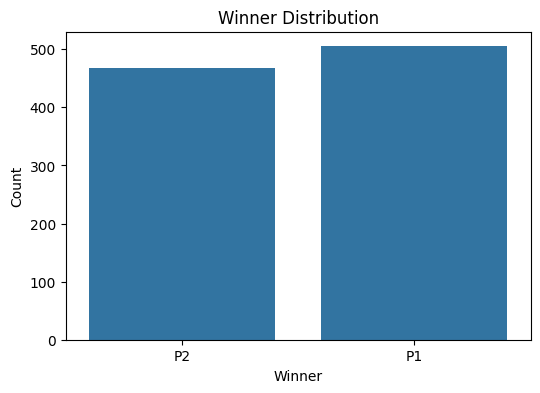

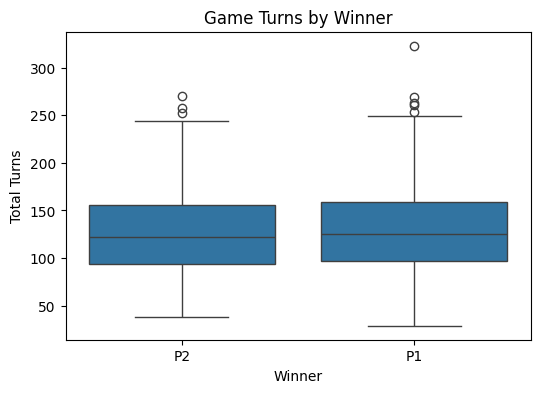

C:\Users\User\AppData\Local\Temp\ipykernel_23276\4194111122.py:49: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='winner', y='p1_final_pieces', data=df, ci=None, color='blue', label='P1')
C:\Users\User\AppData\Local\Temp\ipykernel_23276\4194111122.py:50: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='winner', y='p2_final_pieces', data=df, ci=None, color='red', label='P2', alpha=0.5)


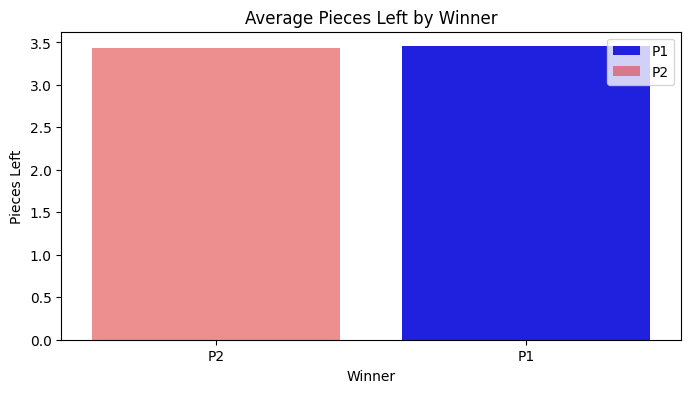

In [2]:
# ========== EDA: วิเคราะห์ผลลัพธ์ strategic_simulation_180games_20250730_142703.csv ==========
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_path = "result-pth-vs-llm/strategic_simulation_180games_20250730_142703.csv"
df = pd.read_csv(csv_path)
print(f'✅ โหลดข้อมูล {len(df)} แถวจาก {csv_path}')

# สรุปข้อมูลเบื้องต้น
print(df.head())
print(df.describe(include='all'))

# สถิติผู้ชนะ
winner_counts = df['winner'].value_counts()
print('\n🏆 สถิติผู้ชนะ:')
for winner, count in winner_counts.items():
    print(f'   • {winner}: {count} เกม ({count/len(df)*100:.1f}%)')

# กลยุทธ์ที่ใช้บ่อย
strategy_counts = df['strategy_used'].value_counts().head(10)
print('\n🎯 กลยุทธ์ที่ใช้บ่อย (10 อันดับแรก):')
for strategy, count in strategy_counts.items():
    print(f'   • {strategy}: {count} ครั้ง')

# วิเคราะห์ตาม pattern
pattern_summary = df.groupby('pattern_id')['winner'].value_counts().unstack(fill_value=0)
print('\n📋 ประสิทธิภาพตาม Pattern:')
print(pattern_summary)

# Visualization: Winner distribution
plt.figure(figsize=(6,4))
sns.countplot(x='winner', data=df)
plt.title('Winner Distribution')
plt.xlabel('Winner')
plt.ylabel('Count')
plt.show()

# Visualization: Average turns by winner
plt.figure(figsize=(6,4))
sns.boxplot(x='winner', y='total_turns', data=df)
plt.title('Game Turns by Winner')
plt.xlabel('Winner')
plt.ylabel('Total Turns')
plt.show()

# Visualization: Pieces left by winner
plt.figure(figsize=(8,4))
sns.barplot(x='winner', y='p1_final_pieces', data=df, ci=None, color='blue', label='P1')
sns.barplot(x='winner', y='p2_final_pieces', data=df, ci=None, color='red', label='P2', alpha=0.5)
plt.title('Average Pieces Left by Winner')
plt.xlabel('Winner')
plt.ylabel('Pieces Left')
plt.legend(['P1', 'P2'])
plt.show()